# LSTM Custom Estimator

From: https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/blogs/timeseries/rnn_cloudmle.ipynb

In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Generate dataset

In [10]:
SEQ_LEN = 10       # samples to generate
TRAIN_SIZE = 1000  # observations in trainset
EVAL_SIZE = 50     # observations in evalset

DATA_PATH = '../data'
TRAIN_FILE = os.path.join(DATA_PATH,'train.csv')
EVAL_FILE = os.path.join(DATA_PATH,'eval.csv')

In [11]:
def create_time_series():
  freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl
  return x

def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in xrange(0, N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


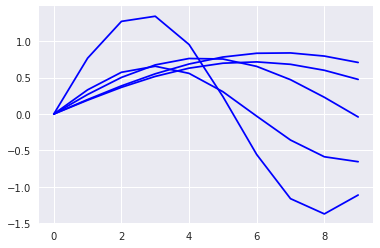

In [12]:
np.random.seed(2020)
for i in xrange(0, 5):
  plt.plot(create_time_series(),'b')

In [13]:
np.random.seed(2020)
if not os.path.exists(DATA_PATH):
    try:
        os.makedirs(value, 0o700)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
to_csv(TRAIN_FILE, TRAIN_SIZE)
to_csv(EVAL_FILE,  EVAL_SIZE)

In [14]:
!head -5 $TRAIN_FILE $EVAL_FILE

==> ../data/train.csv <==
0.0,0.7676795601533715,1.273105193992784,1.343613900164358,0.9551185647307134,0.24033657703041225,-0.5565489526093019,-1.1633067836835487,-1.3726569106009694,-1.113081351630422
0.0,0.2681905727177048,0.5029596158942218,0.6750505436907215,0.7630176282844919,0.7558985361132068,0.654580438365987,0.4716894529656276,0.23001719562566458,-0.04031947903770731
0.0,0.19016946639739402,0.366715454088195,0.5169904516206222,0.6302289651023059,0.6983187433584953,0.7163819284355304,0.6831244986277604,0.6009289704106503,0.4756837182412383
0.0,0.19901515674824055,0.3867880125477004,0.5527113403439096,0.6874121857549668,0.7832813421912355,0.8349031924405768,0.8393616351089137,0.7964048142318099,0.7084593465353177
0.0,0.33259501674824316,0.5735673310108592,0.6565343046087889,0.5586403385242935,0.30685309396104954,-0.02946551252596246,-0.35766701036189597,-0.5873390160854529,-0.6552118810547981

==> ../data/eval.csv <==
0.0,0.5480140772498718,1.011134948244385,1.3176202668383463,

# input_fn

In [15]:
BATCH_SIZE = 20
TIMESERIES_COL = 'rawdata'
N_OUTPUTS = 2  # in each sequence, 1-8 are features, and 9-10 is label
N_INPUTS = SEQ_LEN - N_OUTPUTS
LSTM_SIZE = 3

MODEL_DIR = './model/1d_custom_LSTM'

In [16]:
# read data and convert to needed format
def read_dataset(filename, DEFAULTS, n_outputs, mode=tf.estimator.ModeKeys.TRAIN, batch_size=20):
  def _input_fn():
    num_epochs = 100 if mode == tf.estimator.ModeKeys.TRAIN else 1
    
    # could be a path to one file or a file pattern.
    input_file_names = tf.train.match_filenames_once(filename)
    
    filename_queue = tf.train.string_input_producer(
        input_file_names, num_epochs=num_epochs, shuffle=True)
    reader = tf.TextLineReader()
    _, value = reader.read_up_to(filename_queue, num_records=batch_size)

    value_column = tf.expand_dims(value, -1, name='value')
    print('readcsv={}'.format(value_column))
    
    # all_data is a list of tensors
    all_data = tf.decode_csv(value_column, record_defaults=DEFAULTS)  
    inputs = all_data[:len(all_data)-n_outputs]  # first few values
    label = all_data[len(all_data)-n_outputs : ] # last few values
    
    # from list of tensors to tensor with one more dimension
    inputs = tf.concat(inputs, axis=1)
    label = tf.concat(label, axis=1)
    print('inputs={}'.format(inputs))

    return {TIMESERIES_COL: inputs}, label   # dict of features, label

  return _input_fn
    

In [17]:
def make_model_fn():
  
  def _model_fn(features, labels, mode, params):
    
    # 0. Reformat input shape to become a sequence
    feature_seq = tf.split(features[params['feature_columns']], params['n_inputs'], 1)
    
    # 1. configure the RNN
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(params['lstm_size'], forget_bias=1.0)
    hidden_layers, _ = tf.nn.static_rnn(lstm_cell, feature_seq, dtype=tf.float32)
    
    # slice to keep only the last cell of the RNN
    hidden_layers = hidden_layers[-1]
  
    # output is result of linear activation of last layer of RNN
    predicted_outputs = tf.layers.dense(inputs=hidden_layers, 
                                        units=params['n_outputs'])
    
    # PREDICT
    if mode == tf.estimator.ModeKeys.PREDICT:
      predictions = {
        'output': predicted_outputs,
      }
      return tf.estimator.EstimatorSpec(mode,
                                        predictions=predictions)
    
    # Compute loss.
    loss = tf.losses.mean_squared_error(labels, predicted_outputs)
    
    # Compute evaluation metrics.
    rmse = tf.metrics.root_mean_squared_error(labels, predicted_outputs, name='rmse')

    metrics = {'rmse': rmse}
    tf.summary.scalar('rmse', rmse[1])

    # EVAL
    if mode == tf.estimator.ModeKeys.EVAL:
      return tf.estimator.EstimatorSpec(mode,
                                        loss=loss, 
                                        eval_metric_ops=metrics)
    
    # TRAIN
    assert mode == tf.estimator.ModeKeys.TRAIN
    
    # Create Optimiser
    optimizer = tf.train.AdamOptimizer()

    # Create training operation
    train_op = optimizer.minimize(loss,
                                  global_step=tf.train.get_global_step())

    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
  
  return _model_fn

## Training

In [18]:
! rm -rf $MODEL_DIR

In [19]:
my_checkpointing_config = tf.estimator.RunConfig(
    save_checkpoints_steps = 200,
    #keep_checkpoint_max = 10,
    log_step_count_steps = 200,
    tf_random_seed=2020         # for reproducibility
)

# Build 2 hidden layer DNN with 10, 10 units respectively.
classifier = tf.estimator.Estimator(
  model_fn=make_model_fn(),
  params={'feature_columns': TIMESERIES_COL,
          'n_inputs': N_INPUTS,
          'n_outputs': N_OUTPUTS,
          'lstm_size': LSTM_SIZE},  
  model_dir=MODEL_DIR,
  config=my_checkpointing_config
)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f57a4326b50>, '_evaluation_master': '', '_save_checkpoints_steps': 200, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': 2020, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 200, '_model_dir': './model/1d_custom_LSTM', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


In [20]:
# Train the Model.

DEFAULTS = [[0.0] for x in xrange(0, SEQ_LEN)]
train_spec = tf.estimator.TrainSpec(
  input_fn=read_dataset(TRAIN_FILE, DEFAULTS, N_OUTPUTS,
                        mode=tf.estimator.ModeKeys.TRAIN), 
                        max_steps=1000)

eval_spec = tf.estimator.EvalSpec(
  input_fn=read_dataset(EVAL_FILE, DEFAULTS, N_OUTPUTS,
                        mode=tf.estimator.ModeKeys.EVAL),
  steps=None,          # use complete test set
  start_delay_secs=0,  # start immediately
  throttle_secs=5)     # minimum delay between evaluations

tf.estimator.train_and_evaluate(classifier, train_spec, eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 5 secs (eval_spec.throttle_secs) or training is finished.
readcsv=Tensor("value:0", shape=(?, 1), dtype=string, device=/device:CPU:0)
inputs=Tensor("concat:0", shape=(?, 8), dtype=float32, device=/device:CPU:0)
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./model/1d_custom_LSTM/model.ckpt.
INFO:tensorflow:loss = 0.6926301, step = 1
INFO:tensorflow:Saving checkpoints for 201 into ./model/1d_custom_LSTM/model.ckpt.
INFO:tensorflow:global_step/sec: 97.6026
INFO:tensorflow:loss = 0.4220602, step = 201 (2.054 sec)
INFO:tensorflow:Saving checkpoints for 401 into ./model/1d_custom_LSTM/model.ckpt.
INFO:tensor

In [21]:
# Evaluate the model.
eval_result = classifier.evaluate(
  input_fn=read_dataset(EVAL_FILE, DEFAULTS, N_OUTPUTS,
                        mode=tf.estimator.ModeKeys.EVAL))
print('\nTest set rmse: {rmse:0.3f}\n'.format(**eval_result))

readcsv=Tensor("value:0", shape=(?, 1), dtype=string, device=/device:CPU:0)
inputs=Tensor("concat:0", shape=(?, 8), dtype=float32, device=/device:CPU:0)
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-24-11:40:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/1d_custom_LSTM/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-24-11:40:32
INFO:tensorflow:Saving dict for global step 1000: global_step = 1000, loss = 0.011764114, rmse = 0.10546337

Test set rmse: 0.105



In [22]:
eval_set = np.loadtxt(open(EVAL_FILE, "rb"), delimiter=",", dtype=np.float32)
x_eval = eval_set[:,:-N_OUTPUTS]
y_eval = eval_set[:,-N_OUTPUTS:]

In [23]:
predict_x = {
    'rawdata': x_eval
}
predictions = classifier.predict(
    input_fn=tf.estimator.inputs.numpy_input_fn(predict_x, None, 
                                                batch_size=1, shuffle=False, num_epochs=1))

In [24]:
y_pred = np.empty_like(y_eval)
for idx, pred in enumerate(predictions):
    y_pred[idx,:] = pred['output']

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/1d_custom_LSTM/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


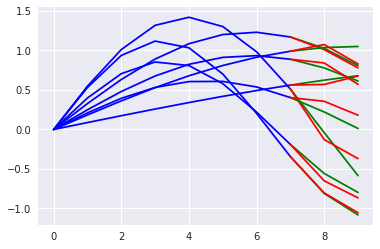

In [25]:
EXAMPLES = 8
past_time = range(SEQ_LEN - N_OUTPUTS)
pred_time = range(SEQ_LEN - N_OUTPUTS-1,SEQ_LEN)

for past, correct, pred in zip(x_eval[:EXAMPLES], y_eval[:EXAMPLES], y_pred[:EXAMPLES]):
  plt.plot(past_time, past,'b')
  plt.plot(pred_time, np.concatenate((past[-1:], correct)),'g')
  plt.plot(pred_time, np.concatenate((past[-1:], pred)),'r')